In [1]:
import os
import time
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym.envs.registration import register
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
def one_hot(x):
    return np.identity(16)[x:x+1].astype(np.float32)

In [3]:
# # entry_point : gym.envs 환경 불러오기
# register(
#     id='LakeEnv-v1',
#     entry_point='gym.envs.toy_text:FrozenLakeEnv',
#     kwargs={'map_name':'4x4', 'is_slippery':True}
# )
# env = gym.make('LakeEnv-v1')

env = gym.make('FrozenLake-v0')

In [4]:
def epsilon(num_episodes):
    for i in range(num_episodes):
      e = 1. / ((i / 50) + 10)
    print(e)

epsilon(2000)

0.020008003201280513


In [5]:
def train_Q(env, optimizer, num_episodes=2000, discounted_reward=.99):
    input_size = env.observation_space.n
    output_size = env.action_space.n

    rList = []

    W = tf.Variable(tf.random.uniform([input_size, output_size], 0, 0.01), dtype=tf.float32)
    optimizer = optimizer

    for i in range(num_episodes):
        # Reset environment and get first new observation
        state = env.reset()
        rAll = 0
        done = False
        local_loss = []

        e = 1. / ((i / 50) + 10)
        # The Q-Table learning algorithm
        while not done:
            # Choose an action by greedly (with a chance of random action)
            # from the Q-network
            q_value = tf.matmul(one_hot(state), W) # 16x16, 16x4 행렬곱 = 1x4 행렬
            q_value = np.array(q_value.numpy())

            if np.random.rand(1) < e:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_value)

            # Get new state and reward from environment
            state_next, reward, done, _ = env.step(action)

            
            if done:
                # Update Q, and no q_value+1, since it's action termial state
                q_value[0, action] = reward

            else:
                # Obtain the Q_s` values by feeding the new state through our network
                q_score_next = tf.matmul(one_hot(state_next), W)
                # Update Q
                q_value[0, action] = reward + discounted_reward * np.max(q_score_next)

            loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.matmul(one_hot(state), W)))
            # optimizer, loss가 작아지는 방향으로 W 업데이트
            optimizer.minimize(loss, var_list=W)
            rAll += reward
            state = state_next
        rList.append(rAll)

    print("Success rate: " + str(sum(rList) / num_episodes))
    #plt.bar(range(len(rList)), rList, color="blue")
    plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
    plt.show()

### 1. SGD

Success rate: 0.504


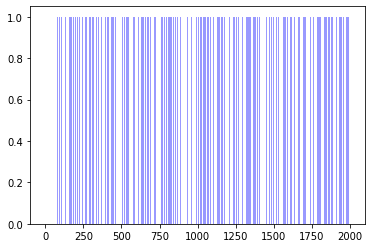

In [6]:
learning_rate=0.1
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
train_Q(env, optimizer=optimizer)

Success rate: 0.402


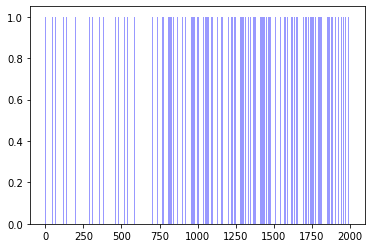

In [7]:
learning_rate=0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
train_Q(env, optimizer=optimizer)

### 2. Adam

Success rate: 0.015


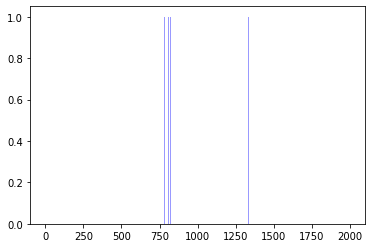

In [8]:
learning_rate=0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_Q(env, optimizer=optimizer)

### 3. RMSprop

Success rate: 0.0155


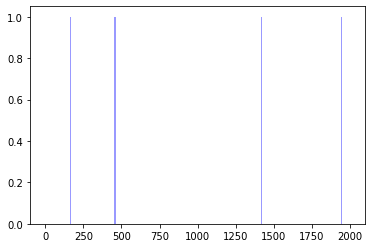

In [9]:
learning_rate=0.1
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
train_Q(env, optimizer=optimizer)

### 4. Adamax

Success rate: 0.354


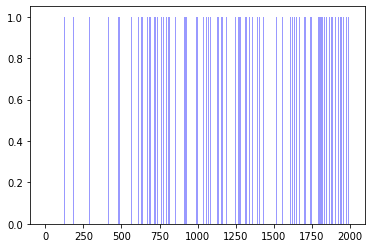

In [10]:
learning_rate=0.1
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
train_Q(env, optimizer=optimizer)